In [0]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

!pip install pyro-ppl
import pyro.distributions as dist
import pyro
from pyro.infer import NUTS, MCMC
from pyro import poutine

     |████████████████████████████████| 409kB 2.7MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


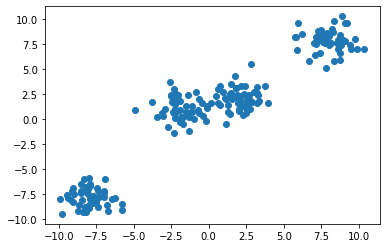

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 6 3 3
 6 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 6 6 6 6 6 6 6 6 6 6 6 6 3 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 6 6 6 6
 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6]


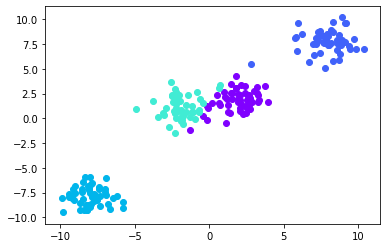

In [0]:
data1 = dist.MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50])
data2 = dist.MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50])
data3 = dist.MultivariateNormal(torch.tensor([2., 2]), torch.eye(2)).sample([50])
data4 = dist.MultivariateNormal(torch.tensor([-2., 1]), torch.eye(2)).sample([50])
data = torch.cat((data1, data2, data3, data4))

plt.scatter(data[:, 0], data[:, 1])
plt.show()

from sklearn.mixture import BayesianGaussianMixture
import matplotlib.cm as cm

k = 9
color=cm.rainbow(np.linspace(0,1,k))
dpmm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=1.5)
dpmm.fit(data)
labels = dpmm.predict(data)
print(labels)

def plot_clusters(data, labels):
    for idx, label in enumerate(np.unique(labels)):
      plt.scatter(data[labels==label, 0], data[labels==label, 1], c=color[idx])
    plt.show()

plot_clusters(data, labels)

In [0]:
pyro.enable_validation(True)

N = len(data)
T = 10

def mix_weights(beta): 
    weights = torch.zeros(beta.shape[0] + 1)
    for t in range(beta.shape[0]):
      weights[t] = beta[t] * torch.prod(1. - beta[:t], dim=0)
    weights[beta.shape[0]] = 1. - torch.sum(weights)
    return weights

def model(data):
    alpha = 1.5 # check alpha 0.3
    with pyro.plate("beta_plate", T-1):
      beta = pyro.sample("beta", dist.Beta(1, alpha))

    with pyro.plate("mu_plate", T):
      mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
      z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
      pyro.sample("obs", dist.MultivariateNormal(mu[z], torch.eye(2)), obs=data)

    # for i in range(N):
    #   z = pyro.sample("z_{}".format(i), dist.Categorical(mix_weights(beta)))
    #   print (z.numpy())
    #   pyro.sample("obs_{}".format(i), dist.MultivariateNormal(mu[z.item()], torch.eye(2)), obs=data[i])

nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=100)
mcmc.run(data)

samples = mcmc.get_samples()
print(samples)

Sample: 100%|██████████| 300/300 [02:37,  2.26it/s, step size=9.44e-02, acc. prob=0.884]

{'beta': tensor([[0.1876, 0.2571, 0.3942,  ..., 0.6145, 0.4775, 0.2573],
        [0.1396, 0.3143, 0.4815,  ..., 0.1411, 0.1763, 0.2564],
        [0.3065, 0.3653, 0.4661,  ..., 0.5822, 0.4484, 0.3970],
        ...,
        [0.2273, 0.3310, 0.5202,  ..., 0.4798, 0.8954, 0.2103],
        [0.2342, 0.2900, 0.4206,  ..., 0.0794, 0.0517, 0.2314],
        [0.2078, 0.2809, 0.3917,  ..., 0.0207, 0.4840, 0.2100]]), 'mu': tensor([[[-1.7917,  0.8027],
         [ 8.1285,  7.5552],
         [-7.8649, -7.8934],
         ...,
         [ 2.9515,  0.8913],
         [ 4.1764, -0.2186],
         [-3.0711,  2.2019]],

        [[-2.1119,  0.7979],
         [ 8.1247,  7.7771],
         [-7.8559, -7.8330],
         ...,
         [ 1.7776,  0.0783],
         [-0.2871, -2.0100],
         [ 0.6340, -1.1289]],

        [[-1.7426,  1.1276],
         [ 7.8513,  7.3803],
         [-7.8737, -7.8735],
         ...,
         [-2.4262,  0.4826],
         [-3.6695,  0.5175],
         [ 0.4022, -2.1667]],

        ...,

  

dict_keys(['beta', 'mu'])
tensor([[-1.8252,  0.9588],
        [ 7.9733,  7.7464],
        [-7.9384, -7.8412],
        [ 1.8194,  1.9895],
        [ 0.3960,  1.0869],
        [-0.1321,  0.8373],
        [-0.3762,  0.2141],
        [-0.1132,  0.3266],
        [ 0.2014,  0.3618],
        [ 0.1975, -0.0858]])
tensor([0.2080, 0.2496, 0.2484, 0.2127, 0.0374, 0.0194, 0.0103, 0.0060, 0.0034,
        0.0048])


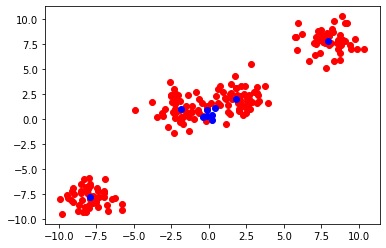

In [0]:
Bayes_Centers = samples['mu'].mean(0)
Bayes_Weights = mix_weights(samples['beta'].mean(0))
# Bayes_Weights = torch.mean(pyro.param("phi").detach(), dim=0)

print (samples.keys())

print (Bayes_Centers)
print (Bayes_Weights) # threshold under 5% and renormalize

plt.scatter(data[:, 0], data[:, 1], color="red")
plt.scatter(Bayes_Centers[:, 0], Bayes_Centers[:, 1], color="blue")
plt.show()